In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns

# Time Series Tasks

### 1. Convert lbp to time series

In [2]:
data = pd.read_csv('patient_longitudinal.csv', delimiter='\t')

# reliable parsing
data['visit_date'] = pd.to_datetime(data['visit_date'], format='%Y-%m-%d')

# set key components and create series with datetimeindex
# clean duplicate
data = data.groupby(['visit_date']).mean().reset_index()
# data = data.drop_duplicates()

# create a pd.Series with DatatimeIndex using visit_date
data.set_index(data['visit_date'], inplace=True)
ts = pd.Series(data['bp_systolic'], index=data['visit_date'])

# consider timezone
ts_ny = ts.tz_localize('America/New_York')
ts_utc = ts_ny.tz_convert('UTC')

# Interpolate missing values
ts = ts.interpolate()
print(ts)

visit_date
2023-01-17    134.4453
2023-02-22    134.4812
2023-03-23    134.3879
2023-04-16    134.5784
2023-06-05    134.4872
2023-06-16    134.5027
2023-06-21    134.5648
2023-07-03    134.4553
2023-08-23    134.4991
2023-10-13    134.6156
2023-10-20    134.5681
2023-12-13    134.6329
2024-01-17    134.6895
2024-03-01    134.6165
2024-03-14    134.7791
2024-04-04    134.7279
2024-04-17    134.5849
2024-05-19    134.7400
2024-05-25    134.8917
2024-07-03    134.8469
2024-10-05    134.7276
2024-10-21    134.8183
2024-11-14    134.7474
2024-12-07    134.6523
2025-01-19    134.7776
2025-02-20    134.5509
2025-02-25    134.5890
2025-03-25    134.6027
2025-04-03    134.4503
2025-06-17    134.2997
2025-06-23    134.2925
2025-07-31    134.4702
2025-08-26    134.3254
2025-11-12    134.3813
2025-12-04    134.3815
2025-12-08    134.3592
2025-12-22    134.3255
2026-01-26    134.3487
2026-02-14    134.3143
2026-04-28    134.5765
2026-05-24    134.2482
2026-05-30    134.5109
2026-06-30    134.5708


### 2. Analyze blood pressure

Text(0, 0.5, 'Values')

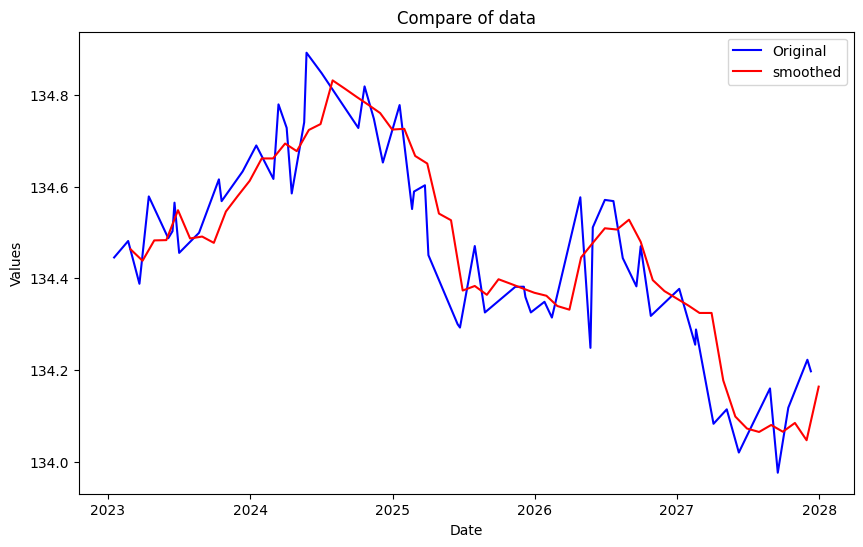

In [3]:
# resample to monthly
ts_mon = ts.resample('ME').mean()
# 3-month moving average
ts_3m = ts_mon.rolling(window=3, min_periods=2).mean()
# remove gaps
ts_3m = ts_3m.interpolate()
# exp
ts_3m.ewm(span=3, min_periods=2)
# visualize
plt.figure(figsize=(10, 6))
plt.plot(ts,label='Original', color='blue')
plt.plot(ts_3m,label='smoothed', color='red')
plt.title('Compare of data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Values')

# Statistical Modeling Task

### 1. Analyze factors

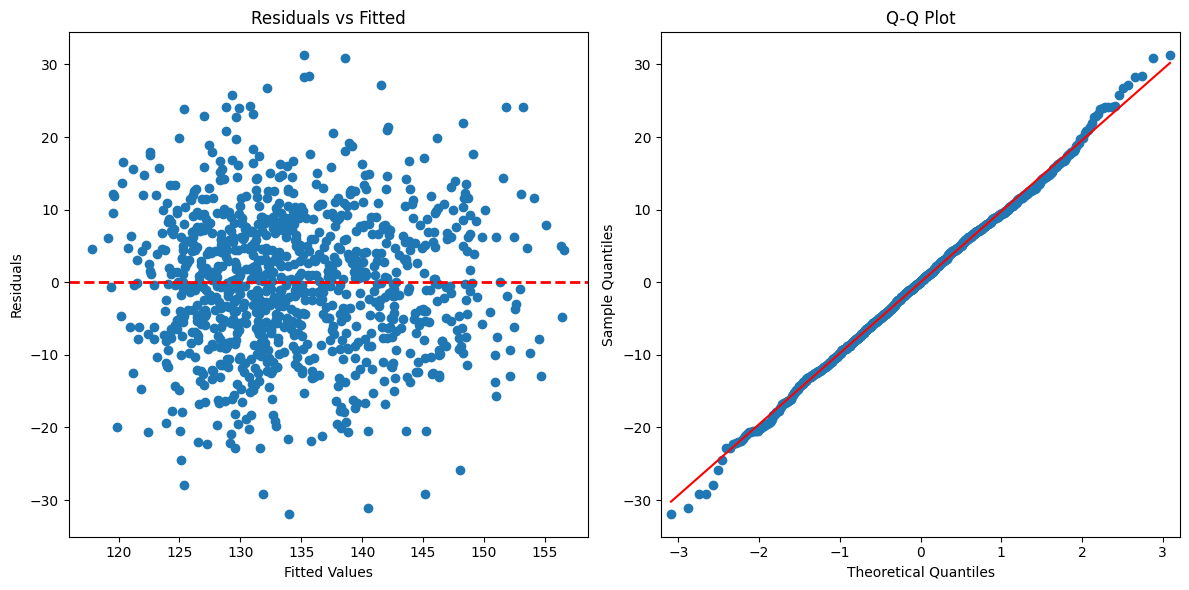

In [4]:
baseline = pd.read_csv('patient_baseline.csv', delimiter='\t')
y = baseline['bp_systolic']
X = baseline.drop(columns=['bp_systolic'])

# use OLS
X = sm.add_constant(X)
model = sm.OLS(y, X)
result = model.fit()
# Residuals vs Fitted values
plt.figure(figsize=(12, 6))

# Residuals vs Fitted
plt.subplot(1, 2, 1)
plt.scatter(result.fittedvalues, result.resid)
plt.axhline(0, linestyle='--', color='red', linewidth=2)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')

# Q-Q plot
plt.subplot(1, 2, 2)
sm.qqplot(result.resid, line='s', ax=plt.gca())
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

### 2. Model Treatment effectiveness

OR and CI:

             Odds Ratio       CI-       CI+
patient_id     0.999820  0.999374  1.000267
age            1.000486  0.990203  1.010876
sex            0.872064  0.673546  1.129092
bmi            1.019073  0.991292  1.047633
smoking        0.571946  0.374209  0.874171
diabetes       0.605309  0.424096  0.863954
bp_systolic    0.997597  0.987207  1.008096
cholesterol    1.002858  0.997178  1.008571
heart_rate     0.996258  0.984805  1.007844
adherence      0.481047  0.150546  1.537109
Residual Deviance: 1313.2400
Null Deviance: 1331.9768


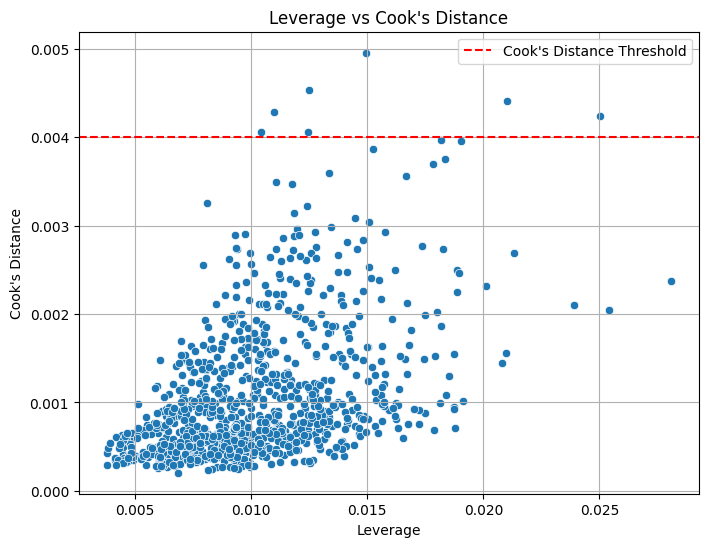

In [5]:
treatment = pd.read_csv('patient_treatment.csv', delimiter='\t')
# Get all column names in df1
col_treatment = treatment.columns.tolist()

# Find common column names in df2
vae = [col for col in col_treatment if col in baseline.columns]
vae.append('adherence')
y = treatment['outcome']
X = treatment[vae]
model2 = sm.GLM(y, X, family=sm.families.Binomial())
results = model2.fit()

# report odds ratios and CI
odds = np.exp(results.params)
conf = np.exp(results.conf_int())

odds_ratios_df = pd.DataFrame({
    'Odds Ratio': odds,
    'CI-': conf[0],
    'CI+': conf[1]
})

print("OR and CI:\n")
print(odds_ratios_df)

# check residual deviance vs null deviance
rd = results.deviance
null = results.null_deviance

print(f"Residual Deviance: {rd:.4f}")
print(f"Null Deviance: {null:.4f}")

# get influential observation
influence = results.get_influence()
leverage = influence.hat_matrix_diag
cooks = influence.cooks_distance[0]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=leverage, y=cooks)
plt.axhline(y=4 / len(y), linestyle='--', color='red', label='Cook\'s Distance Threshold')
plt.grid()
plt.xlabel('Leverage')
plt.ylabel("Cook's Distance")
plt.title("Leverage vs Cook's Distance")
plt.legend()
plt.show()

# Machine Learning Task

### 1. build prediction pipline

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay


# Create ColumnTransformer to handle preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['patient_id', 'age', 'bmi', 'bp_systolic', 'cholesterol', 'heart_rate', 'adherence']), 
        ('cat', OneHotEncoder(), ['sex', 'smoking', 'diabetes']) 
    ]
)

# Create pipeline with specific components
pipeline = make_pipeline(
    preprocessor,
    StandardScaler(),
    SelectKBest(k=5),
    LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced'
    )
)



### 2. validate model performance

Cross-Validated Accuracy: 0.53
Cross-Validated Precision: 0.42
Cross-Validated Recall: 0.57
Cross-Validated ROC AUC: 0.54
confusion matrix:
[[102  83]
 [ 54  61]]

classification report:
              precision    recall  f1-score   support

           0       0.65      0.55      0.60       185
           1       0.42      0.53      0.47       115

    accuracy                           0.54       300
   macro avg       0.54      0.54      0.53       300
weighted avg       0.57      0.54      0.55       300




<Figure size 800x600 with 0 Axes>

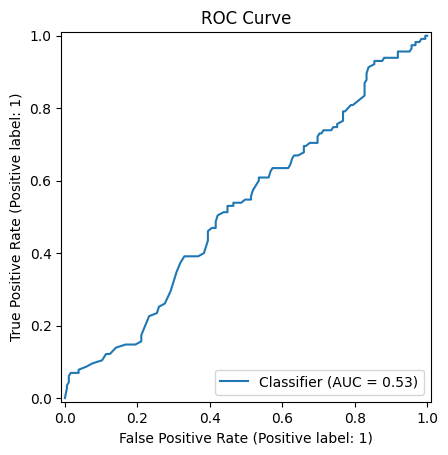

In [7]:
# Stratified split for imbalanced data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y,
    random_state=42
)

# Cross-validation with multiple metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc']
)

# scores
print(f'Cross-Validated Accuracy: {np.mean(scores['test_accuracy']):.2f}')
print(f'Cross-Validated Precision: {np.mean(scores['test_precision']):.2f}')
print(f'Cross-Validated Recall: {np.mean(scores['test_recall']):.2f}')
print(f'Cross-Validated ROC AUC: {np.mean(scores['test_roc_auc']):.2f}')

# prediction
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# results
print(f"confusion matrix:\n{confusion_matrix(y_test, y_pred)}\n")
print(f"classification report:\n{classification_report(y_test, y_pred)}\n")
y_pred_pos = pipeline.predict_proba(X_test)[:, 1]
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, y_pred_pos)
plt.title('ROC Curve')
plt.show()